In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (10,8)
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
from IPython.display import HTML
import csv

[前回](./linear-regression.ipynb)では、線形回帰とはどういうものかについて考え、線形回帰の解析的な解き方ー数式を変形して計算するーで解くことを学びました。**正規方程式**を定義し、それを解いて回帰線の式を得たわけですが、正規方程式では重要な問題が2つあると述べました。逆行列が求めにくいのと、計算の制度が落ちるという理由で、正規方程式が実はあまり使われないと述べました。

となると、ではどのような方法で解ければいいでしょうか。この問の答えになってくれるのが**Gradient Descent**（勾配降下法）です。

# 関数の最適化

まずは簡単な問題から始めましょう。ある関数$y = f(x)$の最小値を知りたい時、どうやって求めればいいでしょうか。当然答えは、$y\prime = 0$と起き、それを満たす$x$を探すわけです。これを**解析的**アプローチと言います。しかし、前回述べたように、解析的に中々解きにくい問題もあります。なので、今度は$y\prime = 0$を解くことを禁止して、別の方法で最小値を探す方法を考えなければなりません。

一つの方法は、あらゆる$x$の値全てに対し$y$を計算し、その中から最小値とその$x$値を選ぶというやり方です。しかし、ご存知のように実数は無限なので、それも中々難しいです。一方、パソコンで表現できる実数は約$2^{64} = 18446744073709551616$通りあるのですが、それら全部を試してみるのを考えると、1秒に1000000000個（そもそも無理）試せたとしても600年ぐらいかかります。というわけで値を全部試すことは無理なので、$x$を賢く選んで、試す値の個数を最低限に抑える方法を探さなければいけません。

ではどうやって$x$の値を選べば良いでしょうか。答えは、「隣の$x$」を見ることです。左隣（負の方向）の$x_l$での$y_l$が自分より大きければ、左（負の方向）に行く必要がありません。一方右隣（正の方向）の$x_r$での$y_r$が自分より小さければ、右（正の方向）に行くと最小値に近づくことになります。しかし残念ながら、この方法も一つ落とし穴があります。皆さんは既に気づいているかもしれませんが、極小値（グラフでの谷）が何個もあると、その中の一つにたどり着いたらそこからもう抜け出すことができません（右も左も自分より大きいので）。これを数学の言葉で言うと、$f(x)$が[Convex Function](https://ja.wikipedia.org/wiki/%E5%87%B8%E9%96%A2%E6%95%B0)（凸関数）の時のみこの方法が最小値を出すことが保証されます。

これ以上賢いことを考えようとすると、話が複雑になるので、今回は最適化したい関数が凸関数であると仮定し、隣を見る方法について解説します。

# 隣を見る

上では「隣の$x$での$y$を見る」と書きましたが、集合に詳しい人は「実数の集合で隣の$x$なんて概念はないよ！」と、心の中で叫んでるはずです。その通りです。$\pi$の隣の数なんてのは定義できないので、数学を語る時は別の捉え方をする必要があります。

良く考えてみると、「隣を見る」時のパターンは4通りあります。一つは、左が小さく、右が大きいパターン。もう一つは、左が大きく、右が小さいパターン。そして残りの2つは、左も右もともに小さい、もしくは大きいパターン。ここまで言うともう分かると思うのですが、「隣を見る」というのは実は微分で表すことができます！微分は関数の変化の激しさを表してくれるので、負の時は1つめのパターン、正の時は2つめのパターン、0の時は3つ目と4つ目のパターンに対応します。

これを図で表すと、以下のようなイメージです。

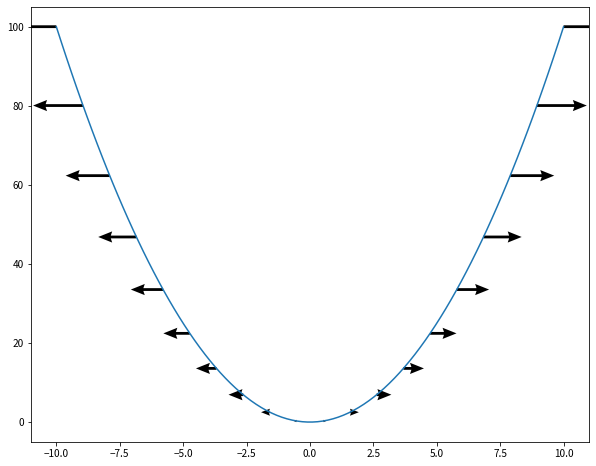

In [3]:
x = np.linspace(-10, 10, 100) # -10から10までの点を等間隔で100個生成
y = x ** 2
fig, ax = plt.subplots(1, 1)
ax.plot(x, y) # 点を通った線を描く
vx = np.linspace(-10, 10, 20)
ax.quiver(vx, vx ** 2, 2 * vx, np.zeros_like(vx), headwidth=4, width=0.005, scale=200) # ベクトル場（矢印）を描く

この図では、微分関数の値が負の時に矢印が左を指し、正の時は右を指します。そして矢印の長さは、微分関数の絶対値に比例します。みての通り、微分はどこに行けば増加するか、そしてどれぐらい増加するかを教えてくれます。もちろん、最小値（谷の底）では微分がゼロ（に近い）ので、矢印の長さが0になっています。

# 微分を使って最適化する

上の話をまとめましょう。まず、関数$f(x)$の微分関数$\frac{df}{dx}$は**増加方向**と**増加程度**を教えてくれます。これを最小値の探索にどう使うのかというと、現在見ている$x_1$からその$x_1$での微分関数の値を引き算すれば良いです。そうすると、どこか新しい$x_2$に辿り着くことができ、その$x_2$に対し$f\prime(x_2) \leq f\prime(x_1)$が成り立ちます。この操作を何回も繰り返せば、微分値がどんどん小さくなっていき、無限回繰り返すと微分値が0に収束します。

しかし、これだけでは不十分です。例えば、$f(x) = x^2$を考えます。この時上の過程を5回繰り返し、辿った$x$を出力してみましょう。最初値は$x=0$で得られるので、そこに近づいていけば正しい動作です。

In [4]:
xs = [-8.0]
print("x_0 =", xs[0])
for i in range(5):
    dfdx = 2 * xs[i]
    xs.append(xs[i] - dfdx)
    print(f"x_{i + 1} = x_{i+1} - f'(x_{i+1}) = ({xs[i]:+}) - ({dfdx:+}) = {xs[i+1]:+}")

x_0 = -8.0
x_1 = x_1 - f'(x_1) = (-8.0) - (-16.0) = +8.0
x_2 = x_2 - f'(x_2) = (+8.0) - (+16.0) = -8.0
x_3 = x_3 - f'(x_3) = (-8.0) - (-16.0) = +8.0
x_4 = x_4 - f'(x_4) = (+8.0) - (+16.0) = -8.0
x_5 = x_5 - f'(x_5) = (-8.0) - (-16.0) = +8.0


$f\prime(x) = 2x$なので、同じ二つの$x$値を交互に辿っているだけです。全く話になりません。

では、$f(x) = 10x^2$はどうなるでしょうか。同じく最小値は$x=0$で得られます。

In [5]:
xs = [-8.0]
print("x_0 =", xs[0])
for i in range(5):
    dfdx = 2 * 10 * xs[i]
    xs.append(xs[i] - dfdx)
    print(f"x_{i + 1} = x_{i+1} - f'(x_{i+1}) = ({xs[i]:+}) - ({dfdx:+}) = {xs[i+1]:+}")

x_0 = -8.0
x_1 = x_1 - f'(x_1) = (-8.0) - (-160.0) = +152.0
x_2 = x_2 - f'(x_2) = (+152.0) - (+3040.0) = -2888.0
x_3 = x_3 - f'(x_3) = (-2888.0) - (-57760.0) = +54872.0
x_4 = x_4 - f'(x_4) = (+54872.0) - (+1097440.0) = -1042568.0
x_5 = x_5 - f'(x_5) = (-1042568.0) - (-20851360.0) = +19808792.0


最小値に辿り着くどころか、どんどん遠ざかっていってます。どういうことかというと、$f\prime(x_i) = f\prime(-x_i)$なので、もし$|x_{i+1}| > |x_i|$になったら、微分値が前より大きくなり、それが繰り返し起こると$x_i$が発散します。（各自図を描いてみて確認しましょう）

というわけで、微分を引くだけだと、$x$が発散したり、二つの値を往復したりしてしまうことになりえるので、何か工夫をしなければいけません。ここで一番簡単な解決策は、微分値を引く前に係数をかけることです。この係数を$\alpha$だとして、$\alpha$が小さければ小さいほど、$x$が動く「歩幅」が小さくなるので、この二つの問題を防ぐことができます。

改めて$f(x) = 10x^2$の最小値を探してみましょう。今回は、$\alpha = 0.04$に設定しておきます。

In [6]:
xs = [-8.0]
alpha = 0.04
print("x_0 =", xs[0])
for i in range(5):
    dfdx = alpha * 2 * 10 * xs[i]
    xs.append(xs[i] - dfdx)
    print(f"x_{i + 1} = x_{i+1} - f'(x_{i+1}) = ({xs[i]:+.3f}) - ({dfdx:+.3f}) = {xs[i+1]:+.3f}")

x_0 = -8.0
x_1 = x_1 - f'(x_1) = (-8.000) - (-6.400) = -1.600
x_2 = x_2 - f'(x_2) = (-1.600) - (-1.280) = -0.320
x_3 = x_3 - f'(x_3) = (-0.320) - (-0.256) = -0.064
x_4 = x_4 - f'(x_4) = (-0.064) - (-0.051) = -0.013
x_5 = x_5 - f'(x_5) = (-0.013) - (-0.010) = -0.003


今回はちゃんと収束しますね！残念ながら、$\alpha$の値は最適化したい関数毎に自分で決めなければいけないです。注意しなければいけないのは、大きすぎると発散が起こり、小さすぎると収束に時間がかかります。

上手な決め方についてはまた今度書きますが、一旦は自分で試してみて、収束するようになるまで小さくしていくという決め方を使いましょう。

# 多次元に一般化する

今までは、1次元関数（変数が一つだけの関数）を最適化しました。しかし、機械学習や深層学習では、次元（変数）がいくらでもあります。線形回帰の場合はまだ10次元以内に収まるかもしれませんが、画像認識になるとピクセル数分の次元（数十万〜数千万）もありえます。しかし、いきなり数千万次元の関数を最適化しろと言われても無理があるので、これからは2次元関数の最適化について解説していきます。

## 多次元での微分

一次元での微分値$f\prime(x_1)$は、$x_1$をどの方向にずらせば$f(x_1)$が大きくなるか、そしてどれぐらい大きくなるかを教えてくれます。2次元になると、動かす物が2個--$x$と$y$--あるので、「どの方向に動かせばいいか」というのは自然とベクトルになります。そして、そのベクトルの絶対値が「どれぐらい大きくなるか」を教えてくれます。

では、このベクトルに何を入れればいいかというと、一つ目の要素には「$x$を動かすとどれぐらい大きくなるか」、もう一つの要素には「$y$を動かすとどれぐらい大きくなるか」を入れれば良いです。方向は符号で決まるのでもちろんそれぞれの符号も必要です。そして、この「◯を動かせば」という制約があるので、ここで偏微分が登場します。

さて、説明はここまでにして、話を数学の言葉に直しましょう。上で言ったベクトルは、**Gradient**（勾配）と言います。そしてその定義は以下です。

$$
\nabla f(x, y, z, ...) = \begin{pmatrix}
\frac{\partial f}{\partial x} \\
\frac{\partial f}{\partial y} \\
\frac{\partial f}{\partial z} \\
...
\end{pmatrix}
$$

ここで一つ注意点を述べましょう。関数が$f(x)$の時、つまり1次元関数である時、勾配は$x$での微分と等しいです。つまり：

$$
\nabla f(x) = \frac{df}{dx}
$$

## 勾配で関数を最適化する

勾配の意味をわかりやすくするために、関数$f(x, y) = x^2 + y^2$を考えましょう。この関数のグラフを描くと、以下の曲面ができます。

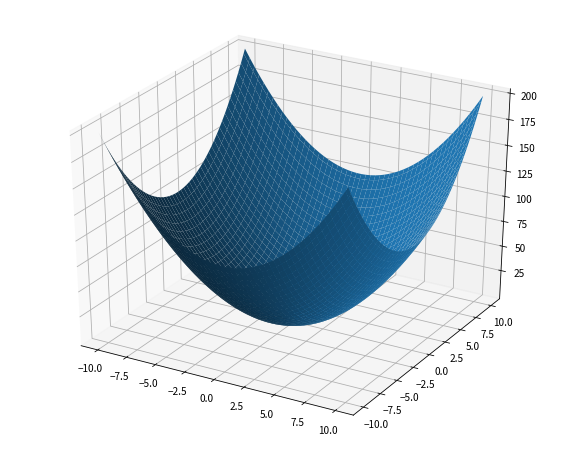

In [7]:
r = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(r, r)
zz = xx ** 2 + yy ** 2
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xx, yy, zz) # 曲面を描く

次に、$f$の勾配を2次平面上に描くとどうなるのでしょうか。勾配の矢印が関数の高いところを指していることを意識して、次の図を描いてみましょう。

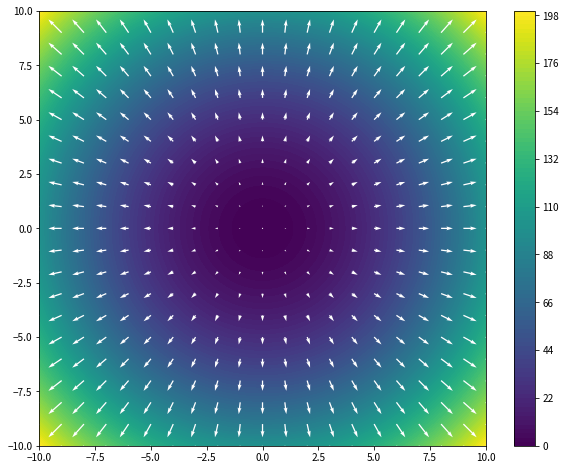

In [8]:
r = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(r, r)
zz = xx ** 2 + yy ** 2
fig = plt.figure()
ax = fig.add_subplot()
c = ax.contourf(xx, yy, zz, levels=100) # 色付き等高線図を描く
fig.colorbar(c)

vr = np.linspace(-10, 10, 21)
vx, vy = np.meshgrid(vr, vr)
dfdx = 2 * vx
dfdy = 2 * vy
ax.quiver(vx, vy, dfdx, dfdy, color='white') # ベクトル場（勾配）を描く

ここで、色は曲面の$z$座標 - $f(x, y)$の値 - を表します。みての通り、$(0, 0$で関数が最小値をとるので、勾配がゼロになるし、そこから遠ざかっていくとどんどん増加が激しくなり、矢印が長くなっていきます。

では、この関数を最適化するにはどうしたら良いのかというと、１次元の時と全く同じです。ただ今回は、$x_i$の変わりに$(x_i, y_i)$ベクトルから勾配ベクトルを引き、更新していきます。つまり：

$$
\begin{pmatrix}
x_{i+1} \\
y_{i+1}
\end{pmatrix} =
\mathbf{v}_{i+1}
= \mathbf{v} - \alpha\nabla f(x_i, y_i)
$$

さて、$f(x, y) = 2x^2 + y^2$を最適化してみましょう。$\alpha$を$0.1$と置いて、10回計算していきます。

In [9]:
v = np.array([-5.0, -8.0])
vs = [v] # vの履歴
alpha = 0.1
print(f"v_0 =", v)
for i in range(10):
    v = v - alpha * np.array([ 4 * v[0], 2 * v[1] ]) # vの更新
    vs.append(v)
    print(f"v_{i+1} =", v)
vs = np.array(vs)

v_0 = [-5. -8.]
v_1 = [-3.  -6.4]
v_2 = [-1.8  -5.12]
v_3 = [-1.08  -4.096]
v_4 = [-0.648  -3.2768]
v_5 = [-0.3888  -2.62144]
v_6 = [-0.23328  -2.097152]
v_7 = [-0.139968  -1.6777216]
v_8 = [-0.0839808  -1.34217728]
v_9 = [-0.05038848 -1.07374182]
v_10 = [-0.03023309 -0.85899346]


確かに$(0, 0)$に収束していきますね。これで何が起きているかイメージ付けるために、$f$の勾配の図で勾配矢印を逆方法に向け、その上に$v_i$が通った点を図示してみましょう。

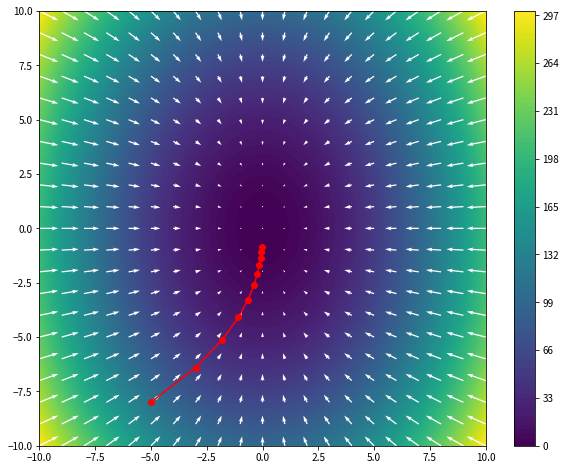

In [10]:
# 上記と同じお絵描き
r = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(r, r)
zz = 2*xx ** 2 + yy ** 2
fig = plt.figure()
ax = fig.add_subplot()
c = ax.contourf(xx, yy, zz, levels=100)
fig.colorbar(c)

vr = np.linspace(-10, 10, 21)
vx, vy = np.meshgrid(vr, vr)
dfdx = -4 * vx
dfdy = -2 * vy
ax.quiver(vx, vy, dfdx, dfdy, color='white')

ax.plot(vs[:, 0], vs[:, 1], color='red') # 上のセルで計算した最適化の履歴
ax.scatter(vs[:, 0], vs[:, 1], color='red')

確かに勾配に従ってそうですね。

一般的に、2次元関数$f(x, y)$が描く曲面は、山と谷のように見えますよね。勾配で最適化をすると、最小値に辿り着くようにいろいろな点を辿るわけですが、その点は必ず前の点より低いところにないといけません。これは言い換えると、山から谷に降りているようなことです。そのイメージから、**Gradient Descent**（勾配降下法）という名前が生まれたのです。

# 勾配降下法と線形回帰

勾配降下法は、関数の最適化を行う方法です。何の関数を最適化するかは全く自由で、その勾配さえ求まれば勾配降下を使うことができます。

今回は、線形回帰に購買降下法を使ってみます。[前回](./linear-regression.ipynb)の内容を思い出してみると、線形回帰ではコスト関数（誤差関数）を最小にするのが目的です。そして、コスト関数は回帰係数$\beta_{ij}$を変数としています。その式を改めて書いてみると以下になります。

$$
J_k(\mathbf{\beta}) = \frac{1}{2}\sum_i^N{\Big(y_k^{(i)} - \hat y_k^{(i)}\Big)^2} = \frac{1}{2}\sum_i^N{\Big(y_k^{(i)} - \sum_j^M \beta_{kj}x_j^{(i)}\Big)^2}
$$

これは、$k$個目の出力（目的変数）に対するコスト$J_k$が、全てのサンプル（データ点）の目的変数の真の値から推測した値を弾いたものの2乗です。さて、この式の勾配は何になるのでしょうか？式を展開してみましょう。


$$
\begin{aligned}
J_k(\mathbf{\beta}) &= \frac{1}{2}\sum_i^N{\Big(y_k^{(i)} - \sum_j^M \beta_{kj}x_j^{(i)}\Big)^2} \\
&= \frac{1}{2}\sum_i^N{ \Big[ (y_k^{(i)})^2 + \Big(\sum_j^M \beta_{kj}x_j^{(i)} \Big)^2 - 2y_k^{(i)}\sum_j^M\Big(\beta_{kj}x_j^{(i)}\Big) \Big]}
\end{aligned}
$$

さて、ここで勾配をとるとどうなるでしょうか？勾配は$\mathbf{\beta}_k$（ベクトル）の要素の個数分の要素を持つわけですので、その一つの要素、$\beta_{kp}$に注目してみましょう。

$$
\def\pd#1{\frac{\partial}{\partial #1}}
\begin{aligned}
(\nabla J_k)_p &= \pd{\beta_{kp}}\frac{1}{2}\sum_i^N{ \Big[ (y_k^{(i)})^2 + \Big(\sum_j^M \beta_{kj}x_j^{(i)} \Big)^2 - 2y_k^{(i)}\sum_j^M\Big(\beta_{kj}x_j^{(i)}\Big) \Big]} \\
&= \frac{1}{2}\sum_i^N{ \Big[ \pd{\beta_{kp}}(y_k^{(i)})^2 + \pd{\beta_{kp}}\Big(\sum_j^M \beta_{kj}x_j^{(i)} \Big)^2 - \pd{\beta_{kp}}2y_k^{(i)}\sum_j^M\Big(\beta_{kj}x_j^{(i)}\Big) \Big]} \\
&= \frac{1}{2}\sum_i^N{\Big[ 2x_p^{(i)}\sum_j^M\Big(\beta_{kj}x_j^{(i)}\Big) - 2y_k^{(i)}x_p^{(i)}\Big]} \\
&= \frac{1}{2}\sum_i^N{2x_p^{(i)}\Big[y_k^{(i)} - \sum_j^M\Big(\beta_{kj}x_j^{(i)}\Big) \Big]} \\
&= \sum_i^N{x_p^{(i)}(y_k^{(i)} - \hat y_k^{(i)})}
\end{aligned}
$$

かなり綺麗な式になってみましたね！これで$\nabla J_k$の全ての要素が同じように求まります。そして、勾配を求めることができたので、後は勾配降下を適用するだけです！そのために、コスト関数とコスト関数の勾配を計算してくれるpython関数と、勾配降下を行い、最適化した答えを返してくれるpython関数を実装しましょう。

In [11]:
# コスト関数は勾配降下では使われませんが、あとから使うので今実装しておきます
def J(B, X, Y):
    yhat = X @ B
    return np.sum((Y - yhat) ** 2, axis=0)

def gradJ(B, X, Y):
    yhat = X @ B
    return np.sum(X * (yhat - Y), axis=0, keepdims=True).T
    
def gradientDescent(X, Y, alpha, iterations):
    B = np.random.rand(X.shape[-1], Y.shape[-1]) # Bの初期値をランダムにする
    Bs = [B] # 通過したBの値を保存
    for i in range(iterations):
        B = B - alpha * gradJ(B, X, Y) # 勾配降下。gJは勾配を計算してくれる関数です
        Bs.append(B)
    return B, Bs

これで勾配降下を行う準備ができました。では、実際にデータを読み込んで、実行してみましょう。

In [12]:
X = []
Y = []
# csvファイルからデータを読み込む
with open('data.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        X.append(float(row[0]))
        Y.append(float(row[1]))
X = np.array(X) # pythonのリストをnumpy arrayに変換する
N = X.shape[0]
X = X.reshape(N, 1) # numpyでは、N次元ベクトルとNx1行列は違う扱いになるので、変換しておきます
X = np.append(X, np.ones((N, 1)), axis=1) # データにバイアス用の1の列を追加します
Y = np.array(Y).reshape((N, 1)) # ベクトル -> 行列変換

B, Bs = gradientDescent(X, Y, 0.000013, 100000)
print(B)

[[1368.83257888]
 [8041.73161539]]


勾配降下の結果は$\mathbf{\beta} = (1369, 8042)$となりました。正規方程式で得た値と同じですね！

次に、実際の勾配降下の軌道を描いてみますが、更にコスト関数のあらゆる値を計算してみて、2次平面で色を使って曲面と勾配を表しましょう。

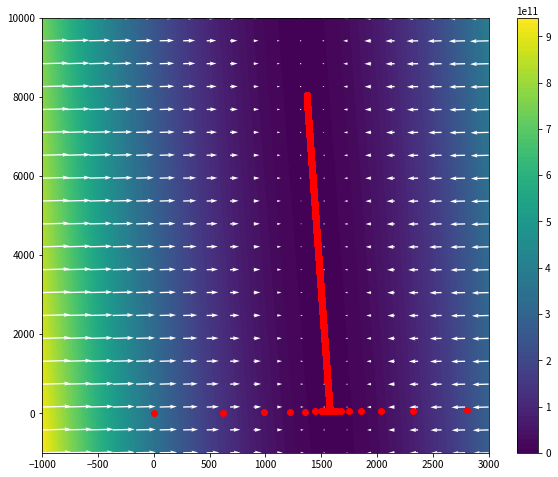

In [13]:
# グラフの範囲
xlim = (-1000, 3000)
ylim = (-1000, 10000)

# 曲面の計算
bx = np.linspace(xlim[0], xlim[1], 100)
by = np.linspace(ylim[0], ylim[1], 100)
bxx, byy = np.meshgrid(bx, by)
bb = np.stack([bxx, byy], axis=2)
B = []
for i in range(100):
    B.append([])
    for j in range(100):
        B[i].append(J(bb[i, j][:, np.newaxis], X, Y))
B = np.array(B).reshape(100, 100)
plt.contourf(bxx, byy, B, levels=100)
plt.colorbar()

# 勾配の計算
V = 20
gx = np.linspace(xlim[0], xlim[1], V)
gy = np.linspace(ylim[0], ylim[1], V)
gxx, gyy = np.meshgrid(gx, gy)
gb = np.stack([gxx, gyy], axis=2)
gB = []
for i in range(V):
    gB.append([])
    for j in range(V):
        gB[i].append(gradJ(gb[i, j][:, np.newaxis], X, Y))
gB = -np.array(gB)
gvx = gB[:, :, 0, 0]
gvy = gB[:, :, 1, 0]
norm = np.sqrt(gvx ** 2 + gvy ** 2)
plt.quiver(gxx, gyy, gvx, gvy, color='white')

# 勾配降下の経路
Bs = np.array(Bs)
plt.scatter(Bs[:, 0, 0], Bs[:, 1, 0], color='red')

少しわかりにくいですが、勾配降下は徐々に$(1369, 8042)$へ近づいていっていますね。最後に、回帰線を描きながら、勾配降下がどのように動いているかを描いてみましょう。

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].contourf(bxx, byy, B, levels=100)
ax[1].scatter(X[:, 0], Y)
ax[1].set_xlim(-10, 80)
ax[1].set_ylim(10000, 100000)

dots = ax[0].scatter([], [], color='red')
gd_dots = []
line = ax[1].plot([], [], color='red')[0]

def update(i):
    b = Bs[(2 ** i), :, 0]
    gd_dots.append(b)
    dots.set_offsets(gd_dots)
    xx = np.linspace(-10, 80)
    xx = np.stack([xx, np.ones_like(xx)], axis=1)
    yy = xx @ b
    line.set_data(xx[:, 0], yy)
    
anim = FuncAnimation(fig, update, frames=int(np.log(Bs.shape[0]) / np.log(2)), interval=1000)
plt.close()
HTML(anim.to_html5_video())